# PyTorch: CV Development

In [1]:
import audiomod
import ptmod

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from functools import partial

import matplotlib.pyplot as plt
# import seaborn as sns
# plt.style.use('seaborn')

from copy import deepcopy
import pickle

%matplotlib inline

In [2]:
# rs = torch.manual_seed(42)

# torch.initial_seed()

## Pull Datagroup

In [3]:
sax1203_dg = audiomod.pull_datagroup_from_db('sax1203')

## CV

### Assign Folds

This function should assign a column of randomly-generated fold values to the datagroup df:

In [4]:
sax1203_cv_df = audiomod.assign_cv_groups(sax1203_dg, folds=5)

In [5]:
sax1203_cv_df.sample(10)

,chunk_id,actual,cv
55,001083,0,0
109,002321,0,3
504,010021,0,1
88,001747,0,2
301,005675,0,2
299,005670,0,2
43,000846,1,2
96,001884,1,0
360,006994,0,2
507,010107,0,2


How well is it stratified?

In [6]:
(sax1203_cv_df
 .groupby(['actual','cv'])
 .count()
)

chunk_id
actual cv          
0      0         92
       1         91
       2         99
       3         83
       4         95
1      0         79
       1         95
       2         87
       3         96
       4        103

Not perfectly, but not horribly either. "Stratify" option on the wish list now.

## Running CV Function

First, define model params:

In [3]:
params = {
    'c1': [5,2,10],
    'p1': [2,2],
    'c2': [5,2,20],
    'p2': [2,2],
    'f1': [700,100],
    'f2': [100,2]
}

And pull the datagroup again:

In [4]:
sax1203_dg = audiomod.pull_datagroup_from_db('sax1203')

In [5]:
cv_scores, scores_bundle, losses = ptmod.crossval(
    params,
    sax1203_dg,
    0.25,
    partial(optim.SGD, lr=0.01, weight_decay=0.1, momentum=0.9),
    nn.CrossEntropyLoss(),
    5,
    8,
    folds=3,
    rs=23
)


*** Fold 1 ***

Train set length: 618
Test set length: 302
Random seed: 23

Epoch 1
 * Avg loss: 0.688	Time: 6307.221 ms
 * Weights updated: True
Epoch 2
 * Avg loss: 0.690	Time: 5848.649 ms
 * Weights updated: True
Epoch 3
 * Avg loss: 0.692	Time: 6265.458 ms
 * Weights updated: True
Epoch 4
 * Avg loss: 0.693	Time: 6420.459 ms
 * Weights updated: True
Epoch 5
 * Avg loss: 0.693	Time: 6438.592 ms
 * Weights updated: True

Training Complete!

Score	Train	Test
------------------------
Acc	0.500	0.500
Rec	0.000	0.000
Spec	1.000	1.000

*** Fold 2 ***

Train set length: 598
Test set length: 322
Random seed: 23

Epoch 1
 * Avg loss: 0.694	Time: 7448.099 ms
 * Weights updated: True
Epoch 2
 * Avg loss: 0.693	Time: 7305.733 ms
 * Weights updated: True
Epoch 3
 * Avg loss: 0.693	Time: 7033.365 ms
 * Weights updated: True
Epoch 4
 * Avg loss: 0.693	Time: 6703.230 ms
 * Weights updated: True
Epoch 5
 * Avg loss: 0.693	Time: 7564.022 ms
 * Weights updated: True

Training Complete!

Score	Train	T

It seems to fall into the "0.693 desert" on every pass, despite the fact that the same initial settings in a single run on the training set usually results in a success. Something I'll need to sort out.

### Can `partial` help with loading the SGD object into our CV function?

In [7]:
# instantiate model
cnn_700 = ptmod.CNN_cpcpff(params)
print(cnn_700)
print("Random seed:", cnn_700.rs)

CNN_cpcpff (
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(2, 2))
  (pool1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(2, 2))
  (pool2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (fc1): Linear (700 -> 100)
  (fc2): Linear (100 -> 2)
)
Random seed: 23


In [8]:
SGD_partial = partial(optim.SGD, lr=0.01, weight_decay=0.01, momentum=0.8)

In [7]:
# optimizer_new = SGD_partial(cnn_700.parameters())

# optimizer_new.param_groups

[{'dampening': 0,
  'lr': 0.01,
  'momentum': 0.8,
  'nesterov': False,
  'params': [Parameter containing:
   (0 ,0 ,.,.) = 
     0.0069  0.0676  0.1788 -0.1260  0.1062
     0.1127 -0.0870  0.0296 -0.1116 -0.0232
     0.0745 -0.1264 -0.1331 -0.1601 -0.0430
    -0.1121  0.0472  0.1333 -0.0352 -0.0293
    -0.1990  0.1018  0.1536  0.1987  0.1540
   
   (1 ,0 ,.,.) = 
    -0.2000 -0.0798  0.1904  0.0358 -0.0324
     0.1914  0.0726  0.1380  0.1011 -0.1740
     0.0315 -0.0821 -0.0420 -0.0848 -0.0082
     0.1290 -0.0436  0.0505  0.0669 -0.1558
     0.1025 -0.1998  0.1335  0.1769 -0.1311
   
   (2 ,0 ,.,.) = 
    -0.1434 -0.1151 -0.0314  0.1499 -0.0614
    -0.0269  0.1479  0.1504 -0.0286 -0.0118
     0.1315 -0.0790  0.0871  0.1069 -0.1523
    -0.1959  0.0386  0.0705 -0.1481 -0.0113
    -0.1690  0.0537  0.1325  0.1682 -0.0142
   
   (3 ,0 ,.,.) = 
    -0.1473 -0.1352  0.1358  0.0192  0.0819
     0.0354  0.1872  0.1094  0.1617  0.0623
    -0.0829  0.0231 -0.1410 -0.1287 -0.1435
    -0.1038  0.18

Looks like yes! Let's try...

In [9]:
# pull tt groups using cv group generator to make sure it's doing the right things

df = audiomod.assign_cv_groups(sax1203_dg)
df.cv.value_counts()

3    234
0    233
1    228
2    225
Name: cv, dtype: int64

In [10]:
i = 1
train_df = (df[df.cv != i]
            .filter(['chunk_id', 'actual'])
            .reset_index(drop=True))
test_df = (df[df.cv == i]
            .filter(['chunk_id', 'actual'])
            .reset_index(drop=True))

print(test_df.shape)
print(train_df.shape)

(228, 2)
(692, 2)


In [11]:
train_4 = ptmod.SpectroDataset(train_df, scaling=0.25)
test_4 = ptmod.SpectroDataset(test_df, scaling=0.25)

In [12]:
loss_by_epoch = ptmod.fit(
    cnn_700,
    train_4, 
    SGD_partial(cnn_700.parameters()), 
    nn.CrossEntropyLoss(), 
    17,
    8
)

Epoch 1
 * Avg loss: 0.689	Time: 7262.273 ms
 * Weights updated: True
Epoch 2
 * Avg loss: 0.671	Time: 7140.178 ms
 * Weights updated: True
Epoch 3
 * Avg loss: 0.653	Time: 7777.367 ms
 * Weights updated: True
Epoch 4
 * Avg loss: 0.635	Time: 7115.564 ms
 * Weights updated: True
Epoch 5
 * Avg loss: 0.608	Time: 8516.819 ms
 * Weights updated: True
Epoch 6
 * Avg loss: 0.568	Time: 7486.213 ms
 * Weights updated: True
Epoch 7
 * Avg loss: 0.532	Time: 7350.905 ms
 * Weights updated: True
Epoch 8
 * Avg loss: 0.487	Time: 8153.735 ms
 * Weights updated: True
Epoch 9
 * Avg loss: 0.475	Time: 8207.209 ms
 * Weights updated: True
Epoch 10
 * Avg loss: 0.467	Time: 8321.266 ms
 * Weights updated: True
Epoch 11
 * Avg loss: 0.431	Time: 8255.347 ms
 * Weights updated: True
Epoch 12
 * Avg loss: 0.406	Time: 7922.971 ms
 * Weights updated: True
Epoch 13
 * Avg loss: 0.404	Time: 8569.583 ms
 * Weights updated: True
Epoch 14
 * Avg loss: 0.383	Time: 7825.661 ms
 * Weights updated: True
Epoch 15
 * Avg

Let's plot loss values and look at train/test scores while we're at it:

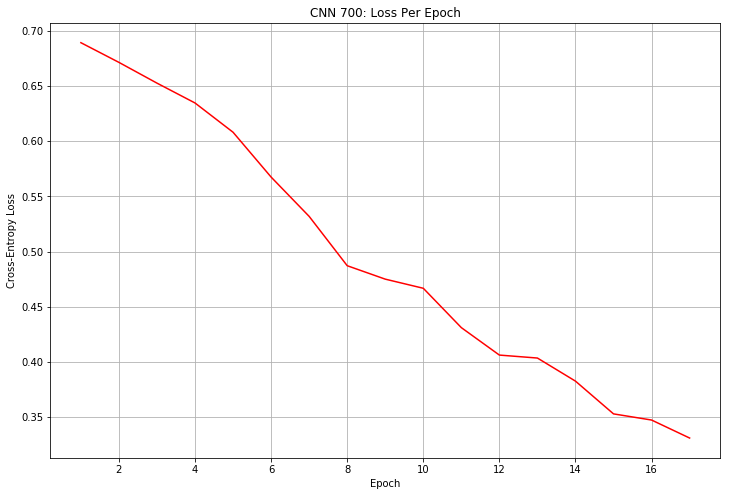

In [13]:
ptmod.plot_loss(loss_by_epoch, 'CNN 700', plot_values='epoch')

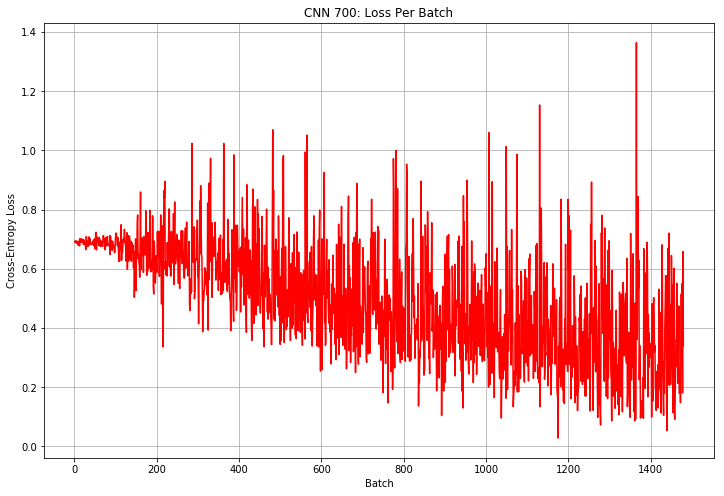

In [14]:
ptmod.plot_loss(loss_by_epoch, 'CNN 700', plot_values='all')

In [15]:
train_4_pred = ptmod.predict(cnn_700, train_4)
test_4_pred = ptmod.predict(cnn_700, test_4)

In [16]:
cnn_700_scores = ptmod.get_scores(train_4_pred, test_4_pred)

In [17]:
ptmod.print_scores(cnn_700_scores, 'CNN 700 15 Epochs')

CNN 700 15 Epochs
Score	Train	Test
------------------------
Acc	0.844	0.781
Rec	0.713	0.640
Spec	0.977	0.915
